In [ ]:
from google.colab import files
from google.colab import drive
import os
import numpy as np
import random as rn
import tensorflow as tf
import zipfile
import cv2
import shutil
import matplotlib.pyplot as plt
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import json

# **Preparation code: dataset download, loading, preprocessing**

In [ ]:
drive.mount('/content/drive', force_remount=True)
!kaggle datasets download -d parsasam/captcha-dataset

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/parsasam/captcha-dataset
License(s): CC0-1.0
100% 355M/356M [00:22<00:00, 20.3MB/s]
100% 356M/356M [00:22<00:00, 16.3MB/s]


In [ ]:
os.environ["PYTHONHASHSEED"] = "0"          # setting the random seed for reproducibility
np.random.seed(150)
rn.seed(150)
tf.random.set_seed(150)

In [ ]:
counter = 0
def unzip_percentage(zip_file, percentage, output_dir):
    global counter
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        num_files_to_extract = int(len(file_list) * (percentage / 100))
        files_to_extract = random.sample(file_list, num_files_to_extract)

        for file in files_to_extract:
            zip_ref.extract(file, output_dir)
            counter += 1
            if counter % 20000 == 0:
                print(f'Unzipped {counter} images...')


zip_file = '/content/captcha-dataset.zip'
output_dir = '/content/CAPTCHA'
percentage = 100

unzip_percentage(zip_file, percentage, output_dir)
print(f'Unzipped {counter} images...')
print('--------------------------------')
print(f'Total CAPTCHAs: {len(os.listdir(output_dir))}')

Unzipped 20000 images...
Unzipped 40000 images...
Unzipped 60000 images...
Unzipped 80000 images...
Unzipped 100000 images...
Unzipped 113062 images...
--------------------------------
Total CAPTCHAs: 113062


In [ ]:
def convert_images_to_grayscale(source_dir, dest_dir):
    if not os.path.exists(dest_dir):        # Create destination directory if it doesn't exist
        os.makedirs(dest_dir)

    counter = 0
    for filename in os.listdir(source_dir):         # Iterate over source directory
        file_path = os.path.join(source_dir, filename)
        save_path = os.path.join(dest_dir, filename)

        image = cv2.imread(file_path)       # Read image

        if image is not None:   # Image was read successfully
            counter += 1
            if counter % 20000 == 0:
                print(f'Converted {counter} images...')
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # Convert image to grayscale
            cv2.imwrite(save_path, gray_image)      # Save the grayscale image to destination
        else:
            print(f"Could not read image: {file_path}")


def remove_original_images(source_dir):
    try:
        shutil.rmtree(source_dir)   # Remove the original images directory and its contents
        print(f"Removed original images from {source_dir}")
    except Exception as e:
        print(f"An error occurred: {e}")


source_dir = '/content/CAPTCHA'
dest_dir = '/content/CAPTCHA_grayscale'

convert_images_to_grayscale(source_dir, dest_dir)   # Convert images in source_dir to grayscale and save to dest_dir
print()
print(f'Total grayscale CAPTCHAs: {len(os.listdir(dest_dir))}')
remove_original_images(source_dir)          # Remove original images directory
os.remove('/content/captcha-dataset.zip')       # Remove zip file

Converted 20000 images...
Converted 40000 images...
Converted 60000 images...
Converted 80000 images...
Converted 100000 images...

Total grayscale CAPTCHAs: 113062
Removed original images from /content/CAPTCHA


In [ ]:
root_folder = '/content/CAPTCHA_grayscale'

In [ ]:
# IMAGE PREPROCESSING AND DATASET SPLITTING

def extract_chars(path):
    char_list = []
    for filename in os.listdir(path):
        filename = os.path.splitext(filename)[0]
        char_list.extend(filename)
    char_list.sort()
    unique_chars = []
    for char in char_list:
        if char not in unique_chars:
            unique_chars.append(char)
    tot_chars = len(unique_chars)
    return tot_chars, unique_chars


def preprocess_images(root_folder):
    image_files = os.listdir(root_folder)
    TOTAL_SAMPLES = len(os.listdir(root_folder))         # Initialize arrays
    X = np.zeros((TOTAL_SAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), dtype=np.float32)
    y = np.zeros((TOTAL_SAMPLES, CAPTCHA_LENGTH, TOT_CAPTCHA_CHARS), dtype=np.float32)

    for i, picture in enumerate(image_files):       # Process each image
        image_path = os.path.join(root_folder, picture)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    # Read the image in grayscale
        if image is None:
            print(f"Warning: {picture} could not be read.")
            continue

        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the image to the expected dimensions
        image = image / 255.0       # Normalize the image
        X[i] = np.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))  # Reshape the image

        label = os.path.splitext(picture)[0]    # Get the label from filename

        target = np.zeros((CAPTCHA_LENGTH, TOT_CAPTCHA_CHARS), dtype=np.float32)     # Initialize target array

        # Encode the label into one-hot format
        for letter_idx, letter in enumerate(label):
            if letter in CAPTCHA_CHARS_STRING:
                index = CAPTCHA_CHARS_STRING.index(letter)
                target[letter_idx, index] = 1

        y[i] = target

        if (i + 1) % 20000 == 0:
            print(f'Processed {i + 1} images...')

    print(f'Processed {TOTAL_SAMPLES} images...')
    return X, y


# Splitting the dataset into training, validation and test sets
def split_data(X, y, validation_size=0.2, test_size=0.1, random_state=150):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(validation_size + test_size), random_state=random_state)
    val_size = validation_size / (validation_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)

    return X_train, y_train, X_val, y_val, X_test, y_test


# CONSTANTS
TOT_CAPTCHA_CHARS, CAPTCHA_CHARS = extract_chars(root_folder)       #60 chars, 123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
IMAGE_HEIGHT = 40
IMAGE_WIDTH = 150
CHANNELS = 1                # Greyscale
CAPTCHA_LENGTH = 5
TOTAL_SAMPLES = len(os.listdir(root_folder))
CAPTCHA_CHARS_STRING = ''.join(CAPTCHA_CHARS)

print(CAPTCHA_CHARS_STRING)
print('CAPTCHA chars: ', CAPTCHA_CHARS)
print('Tot CAPTCHA chars: ', TOT_CAPTCHA_CHARS)
print('Total samples: ', TOTAL_SAMPLES)
print()

# PREPROCESSING AND SPLITTING INTO TRAINING, VALIDATION AND TEST
X, y = preprocess_images(root_folder)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnpqrstuvwxyz
CAPTCHA chars:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Tot CAPTCHA chars:  60
Total samples:  113062

Processed 20000 images...
Processed 40000 images...
Processed 60000 images...
Processed 80000 images...
Processed 100000 images...
Processed 113062 images...
X_train shape: (79143, 40, 150, 1)
y_train shape: (79143, 5, 60)
X_val shape: (11306, 40, 150, 1)
y_val shape: (11306, 5, 60)
X_test shape: (22613, 40, 150, 1)
y_test shape: (22613, 5, 60)


In [ ]:
EPOCHS = 100
BATCH_SIZE = 64

# MODEL ARCHITECTURE DEFINITION
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),             # random rotation within 10%
    layers.RandomZoom(0.2),      # random zoom within 10%
    layers.RandomTranslation(0.2, 0.2),  # Randomly translate image within 10% of width/height
    layers.RandomBrightness(0.3),  # Randomly change brightness within ±20%
    layers.RandomContrast(0.3)    # Randomly change contrast within ±20%
])

img = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
augmented = data_augmentation(img)

conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(img)
mp1 = layers.MaxPooling2D(padding='same')(conv1)

conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(mp1)
mp2 = layers.MaxPooling2D(padding='same')(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(mp2)
mp3 = layers.MaxPooling2D(padding='same')(conv3)

conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(mp3)
bn = layers.BatchNormalization()(conv4)
mp4 = layers.MaxPooling2D(padding='same')(bn)

flat = layers.Flatten()(mp4)

outs = []
for _ in range(CAPTCHA_LENGTH):  # length of the CAPTCHA
    dens1 = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(flat)
    drop = layers.Dropout(0.5)(dens1)
    res = layers.Dense(TOT_CAPTCHA_CHARS, activation='softmax')(drop)
    outs.append(res)

model = keras.Model(inputs=img, outputs=outs)

# MODEL COMPILATION
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=['categorical_crossentropy'] * CAPTCHA_LENGTH,
    metrics=['accuracy'] * CAPTCHA_LENGTH
)

model.summary()

# CALLBACKS
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# MODEL FITTING
history = model.fit(
    X_train,
    [y_train[:, i, :] for i in range(CAPTCHA_LENGTH)],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, [y_val[:, i, :] for i in range(CAPTCHA_LENGTH)]),
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40, 150, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 40, 150, 16)    │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 20, 75, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 20, 75, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 10, 38, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 10, 38, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 5, 19, 64)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 5, 19, 128)     │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 5, 19, 128)     │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 3, 10, 128)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3840)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        491,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        491,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        491,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │        491,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │        491,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├──────────────────────

 Total params: 2,594,604 (9.90 MB)

 Trainable params: 2,594,348 (9.90 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - dense_1_accuracy: 0.0172 - dense_3_accuracy: 0.0171 - dense_5_accuracy: 0.0172 - dense_7_accuracy: 0.0161 - dense_9_accuracy: 0.0178 - loss: 21.5358 - val_dense_1_accuracy: 0.0211 - val_dense_3_accuracy: 0.0168 - val_dense_5_accuracy: 0.0172 - val_dense_7_accuracy: 0.0200 - val_dense_9_accuracy: 0.0204 - val_loss: 20.9920 - learning_rate: 1.0000e-04
Epoch 2/100
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - dense_1_accuracy: 0.0291 - dense_3_accuracy: 0.0200 - dense_5_accuracy: 0.0205 - dense_7_accuracy: 0.0245 - dense_9_accuracy: 0.0248 - loss: 20.8223 - val_dense_1_accuracy: 0.1824 - val_dense_3_accuracy: 0.1001 - val_dense_5_accuracy: 0.0795 - val_dense_7_accuracy: 0.0961 - val_dense_9_accuracy: 0.1390 - val_loss: 18.2736 - learning_rate: 1.0000e-04
Epoch 3/100
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - dense_1_accuracy: 0.1675 - dense_3_accuracy: 0.1060 - dense_5_accuracy: 0.0930 - dense_7_accuracy: 0.0943 - dense_9_accurac

In [ ]:
saved_models = os.listdir("/content/drive/MyDrive/IS_project/models")
tot_saved_models = len(saved_models)

now = datetime.now()
date_time = now.strftime("%m-%d-%Y_%H-%M-%S")

model_name = "regularized_model-" + date_time + ".keras"

model.save(os.path.join("/content/drive/MyDrive/IS_project/models", model_name))

In [ ]:
history_dict = history.history

with open('/content/drive/MyDrive/IS_project/models/regularized_history.json', 'w') as f:
    json.dump(history_dict, f)

In [ ]:
print(history.history.keys())

dict_keys(['dense_1_accuracy', 'dense_3_accuracy', 'dense_5_accuracy', 'dense_7_accuracy', 'dense_9_accuracy', 'loss', 'val_dense_1_accuracy', 'val_dense_3_accuracy', 'val_dense_5_accuracy', 'val_dense_7_accuracy', 'val_dense_9_accuracy', 'val_loss', 'learning_rate'])


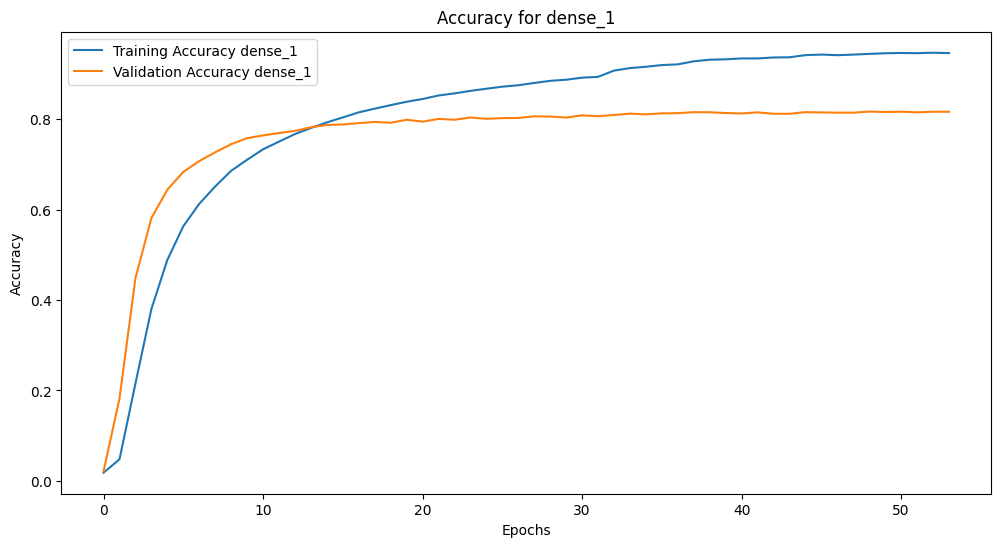

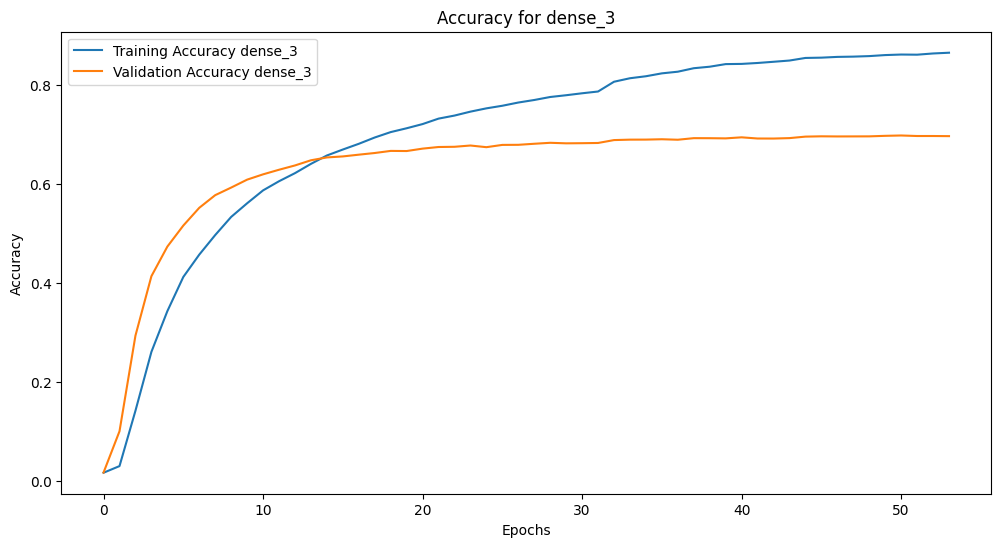

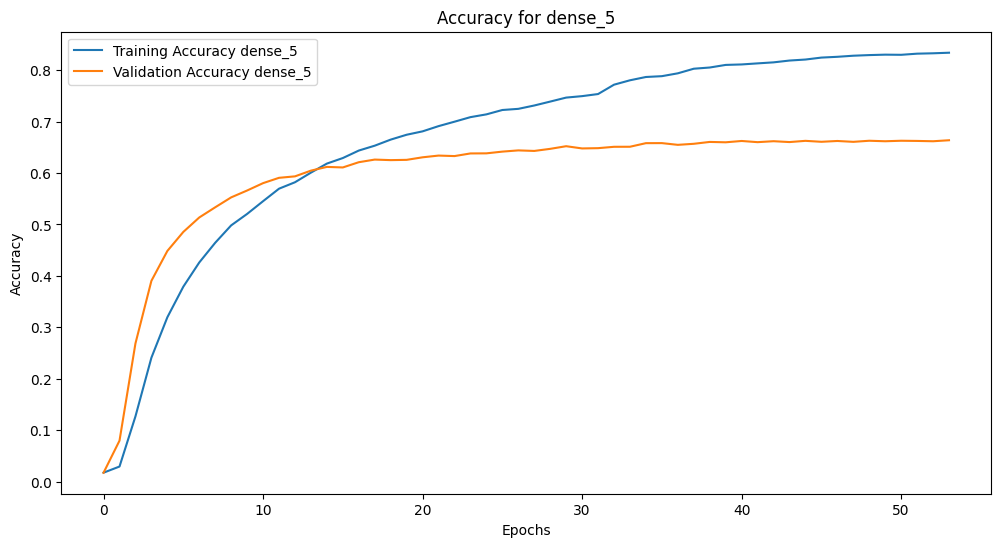

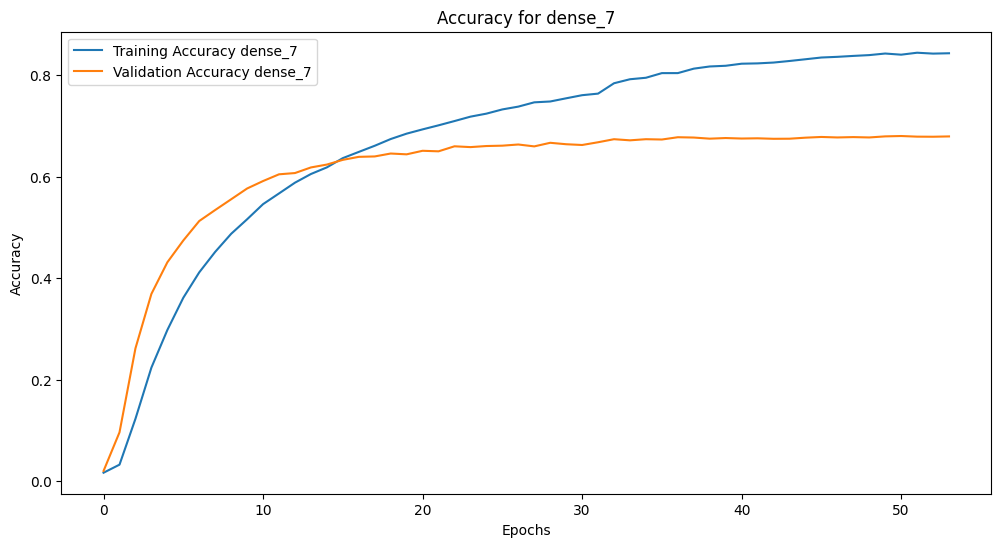

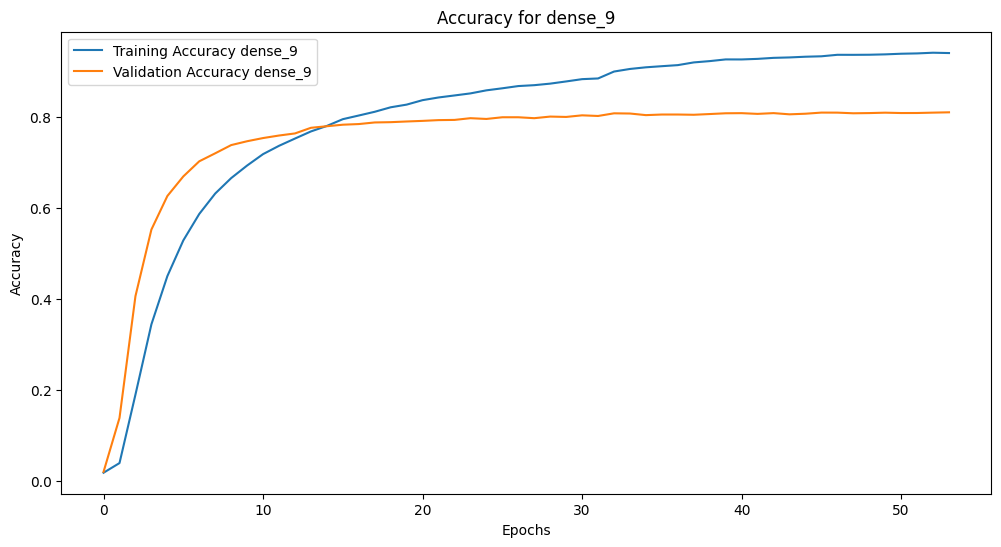

In [ ]:
ids = [1, 3, 5, 7, 9]

def plot_output_accuracy(id):
    output_name = f'dense_{id}'
    plt.figure(figsize=(12, 6))

    plt.plot(history.history[output_name + '_accuracy'], label=f'Training Accuracy {output_name}')

    plt.plot(history.history[f'val_{output_name}_accuracy'], label=f'Validation Accuracy {output_name}')

    plt.title(f'Accuracy for {output_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

for id in ids:
    plot_output_accuracy(id)

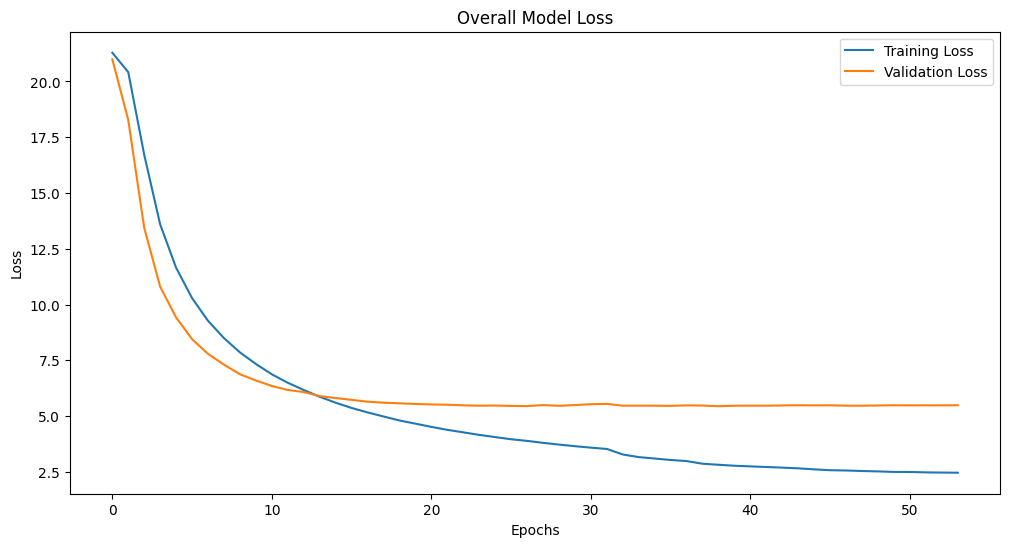

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overall Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

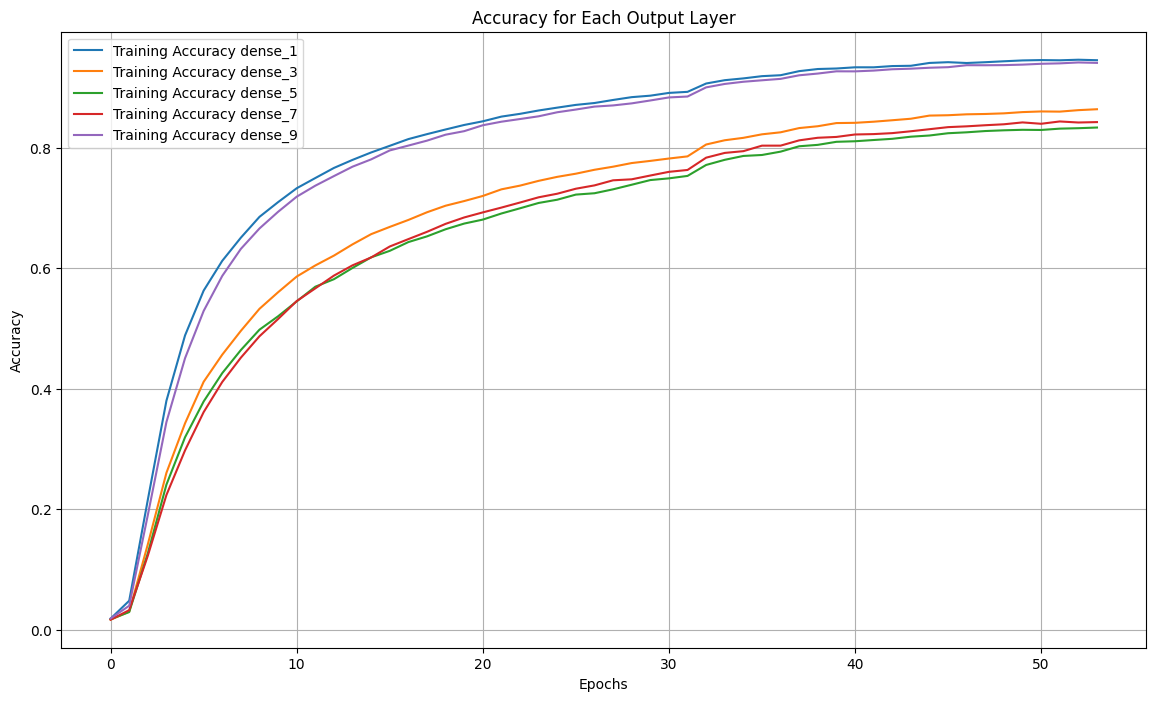

In [ ]:
output_layers = [1, 3, 5, 7, 9]  # Update this list based on your actual output layers

plt.figure(figsize=(14, 8))

for i in output_layers:
    output_name = f'dense_{i}'
    plt.plot(history.history[f'{output_name}_accuracy'], label=f'Training Accuracy {output_name}')      #plot training acc
plt.title('Accuracy for Each Output Layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# TEST PHASE and PREDICTIONS


def decode_labels(y_labels):
    decoded_labels = []
    for i in range(y_labels.shape[0]):
        captcha = ""
        for j in range(CAPTCHA_LENGTH):
            # Get the most probable class index for this character position
            label_index = np.argmax(y_labels[i, j])
            captcha += CAPTCHA_CHARS_STRING[label_index]
        decoded_labels.append(captcha)
    return decoded_labels


def decode_prediction(predictions):
    num_samples = predictions[0].shape[0]
    decoded = []
    for i in range(num_samples):
        captcha = ""
        for j in range(CAPTCHA_LENGTH):
            pred_index = np.argmax(predictions[j][i])
            captcha += CAPTCHA_CHARS_STRING[pred_index]
        decoded.append(captcha)
    return decoded


def get_tot_recognized_captcha_chars(prediction, ground_truth):
    char_counter = 0
    for i in range(CAPTCHA_LENGTH):
        if prediction[i] == ground_truth[i]:
            char_counter += 1
    return char_counter


def get_correct_char_counts(predictions, ground_truth):
    counts = [0] * (CAPTCHA_LENGTH + 1)  # To count 0 to CAPTCHA_LENGTH correct characters
    for pred, gt in zip(predictions, ground_truth):
        correct_chars = get_tot_recognized_captcha_chars(pred, gt)
        counts[correct_chars] += 1
    return counts


def display_captcha_accuracy_table(counts):
    print("Number of Captchas Guessed Correctly:")
    for i in range(CAPTCHA_LENGTH, -1, -1):
        print(f"{i} chars: {counts[i]}")


test_loss, *test_acc = model.evaluate(X_test, [y_test[:, i, :] for i in range(CAPTCHA_LENGTH)], verbose=2)

print(f"Test Loss: {test_loss}")
print()
acc_sum = 0
for i, acc in enumerate(test_acc):
    print(f"Accuracy for character {i + 1}: {acc}")
    acc_sum += acc

print()
print(f'Average accuracy: {acc_sum / 5}')

print()
predictions = model.predict(X_test)             # Prediction on the test set
decoded_predictions = decode_prediction(predictions)            # Decoding the predictions
decoded_actuals = decode_labels(y_test)         #Decoding y_test for comparison

DISPLAYED_PREDICTIONS = 20
for i in range(DISPLAYED_PREDICTIONS):
    ground_truth = ''.join([CAPTCHA_CHARS_STRING[np.argmax(char)] for char in y_test[i]])
    print(f"Prediction: {decoded_predictions[i]}, Ground truth: {ground_truth}, #Recognized CAPTCHA chars: {get_tot_recognized_captcha_chars(decoded_predictions[i], ground_truth)}")

print()
counts = get_correct_char_counts(decoded_predictions, decoded_actuals)
display_captcha_accuracy_table(counts)

707/707 - 8s - 12ms/step - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.6865 - dense_5_accuracy: 0.6542 - dense_7_accuracy: 0.6732 - dense_9_accuracy: 0.8071 - loss: 5.5537
Test Loss: 5.55374002456665

Accuracy for character 1: 0.8091805577278137
Accuracy for character 2: 0.6864635348320007
Accuracy for character 3: 0.6541812419891357
Accuracy for character 4: 0.6731968522071838
Accuracy for character 5: 0.8071463108062744

Average accuracy: 0.7260336995124816

707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Prediction: Tz4xJ, Ground truth: Tz4xJ, #Recognized CAPTCHA chars: 5
Prediction: yiU6F, Ground truth: y1UGF, #Recognized CAPTCHA chars: 3
Prediction: zzvOS, Ground truth: zzvQS, #Recognized CAPTCHA chars: 4
Prediction: LVdqP, Ground truth: LVdqP, #Recognized CAPTCHA chars: 5
Prediction: fzXcn, Ground truth: f4XCn, #Recognized CAPTCHA chars: 3
Prediction: IeEjG, Ground truth: feEjO, #Recognized CAPTCHA chars: 3
Prediction: tdba7, Ground truth: tdba7, #Recognized CAPTCHA chars: 5
Predicti